### Part 1: Exploratory Data Analysis
1. Ensuring data quality
2. Plotting clear and meaningful figures
3. Checking possibly redundant variables via correlations
4. Giving insights on what seems relevant for prediction and what does not

In [1]:
#!pip install holidays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
#from sklearn.pipeline import pipeline
from sklearn.linear_model import LinearRegression
import holidays
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

df = pd.read_csv("hour.csv", parse_dates = ['dteday'], dayfirst = True, index_col = ['dteday'])
df = df.rename(columns={'weathersit':'weather_condition','hum':'humidity','cnt':'total_count','hr':'hour'}) #renaming columns
df.index.names=["datetime"] #renaming the index
df = df.drop(["casual","registered", "instant"], axis=1) #dropping columns we don't predict on

In [2]:
print(f"There are {np.shape(df)[0]} rows and {np.shape(df)[1]} columns in the data set.")
print(f"Number of NaN values in the train data: {df.isnull().sum().sum()}")

There are 17379 rows and 7 columns in the data set.
Number of NaN values in the train data: 499


All features that should be numerical are numerical, the only categorical feature is weather_condition which is what we expected.

In [3]:
#get overview of data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hour               17379 non-null  int64  
 1   weather_condition  17279 non-null  object 
 2   temp               17280 non-null  float64
 3   atemp              17279 non-null  float64
 4   humidity           17279 non-null  float64
 5   windspeed          17279 non-null  float64
 6   total_count        17379 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 1.1+ MB


Our features are on different scales (look at min and max), therefore need scaling.

In [4]:
df.describe()

,hour,temp,atemp,humidity,windspeed,total_count
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,189.463088
std,6.914405,0.192474,0.171782,0.193047,0.122378,181.387599
min,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,977.000000


Our target variable (total_count) does not have NaNs, therefore we do not need to drop any rows where the target has NaNs.
We will handle NaNs later in the code.

In [5]:
df.isnull().sum()

hour                   0
weather_condition    100
temp                  99
atemp                100
humidity             100
windspeed            100
total_count            0
dtype: int64

Bike demand is steadily increasing. The graph indicates that there is seasonality as bike demand is lower in winter months, which makes sense as we typically have less sunshine and simply worse weather conditions in these months.

Text(0.5, 0.98, 'Bike Demand Jan 2011 - Jan 2013')

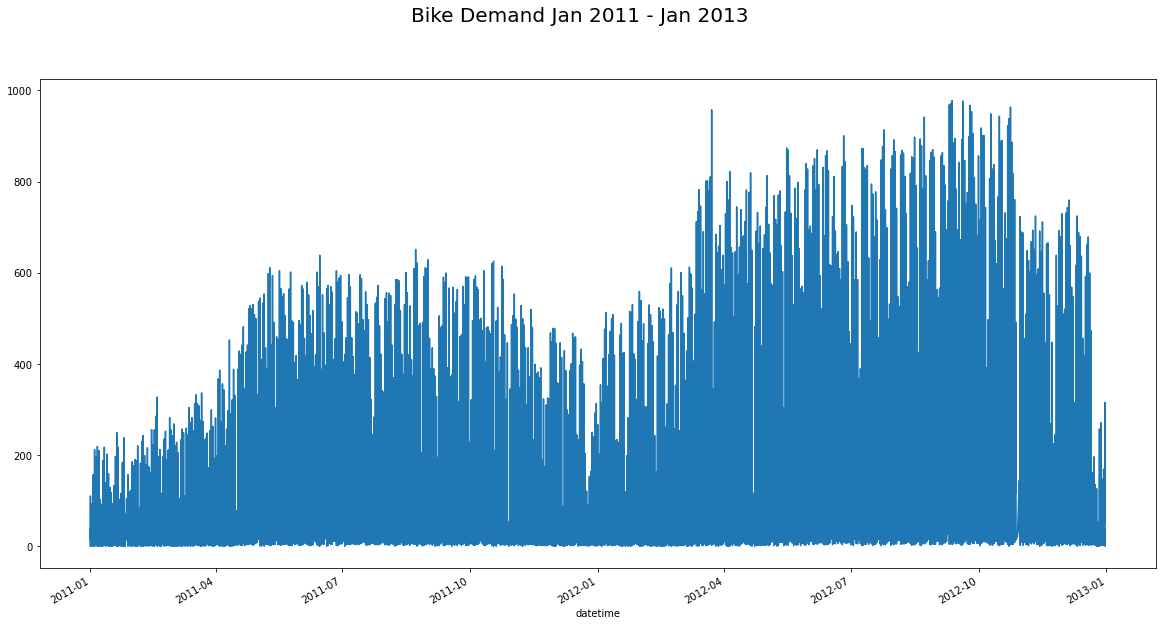

In [6]:
df["total_count"].plot(figsize=(20, 10))
plt.suptitle("Bike Demand Jan 2011 - Jan 2013", fontsize = 20)

The distribution graphs show that our target (total_count) is highly skewed. We thought about normalizing it, but it decreased both our Linear Regression and Random Forest Regression model accuracies. As for the other variables we need to scale them as they are all on different scales

array([[<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>],
       [<AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'total_count'}>]], dtype=object)

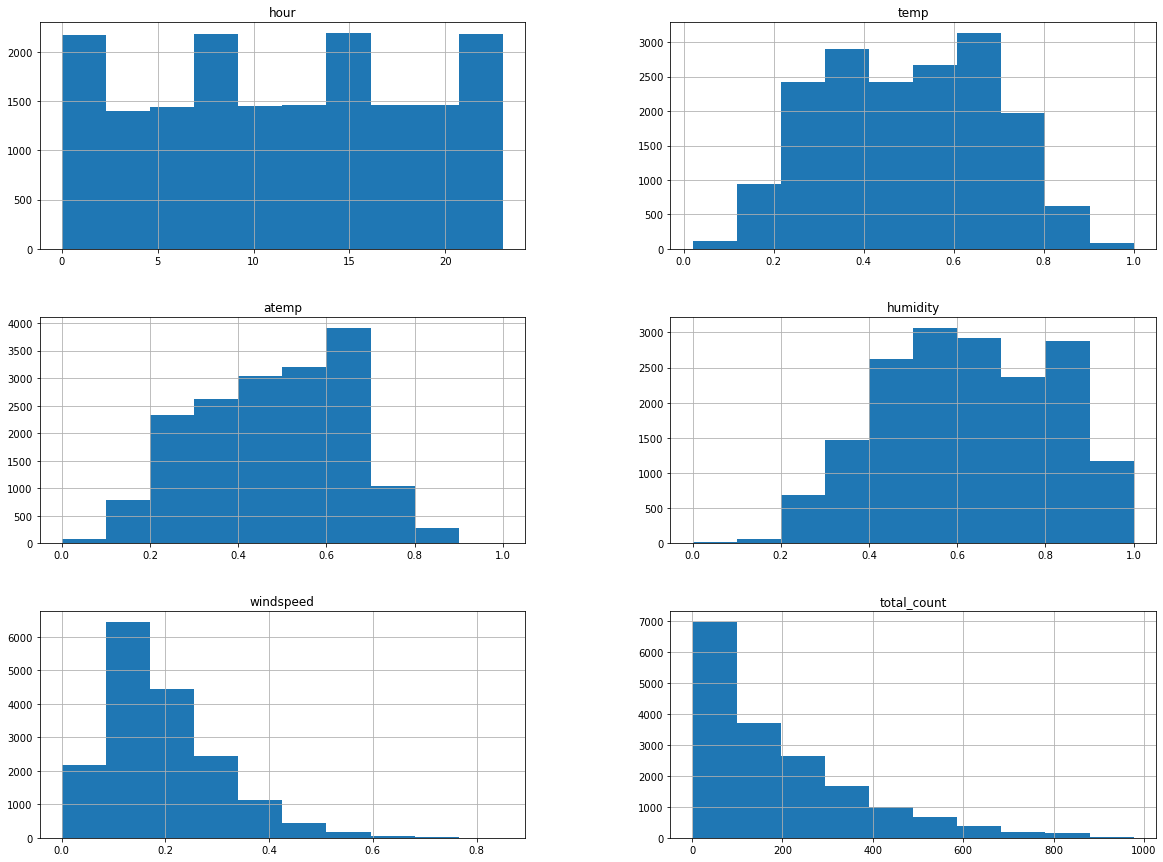

In [7]:
#distribution for all features
df.hist(figsize=(20,15))

The correlation matrix of our initial features gives us some valuable hints such as correlation close to 1 for temp and atemp. This is logical as atemp is the temperature people feel (if the real temperature is cold, the felt temperature will be low too and vice versa). Moreover, there seems to be a high negative correlation between windspeed and humidity.
A variables that seems to be important for our prediction is humidity as it is highly (negatively) correlated with. 
All of these findings we well investigate and try to verify again later, also in interaction with newly created features to see which ones to keep and which ones to drop.

Text(0.5, 1.0, 'Correlation Matrix')

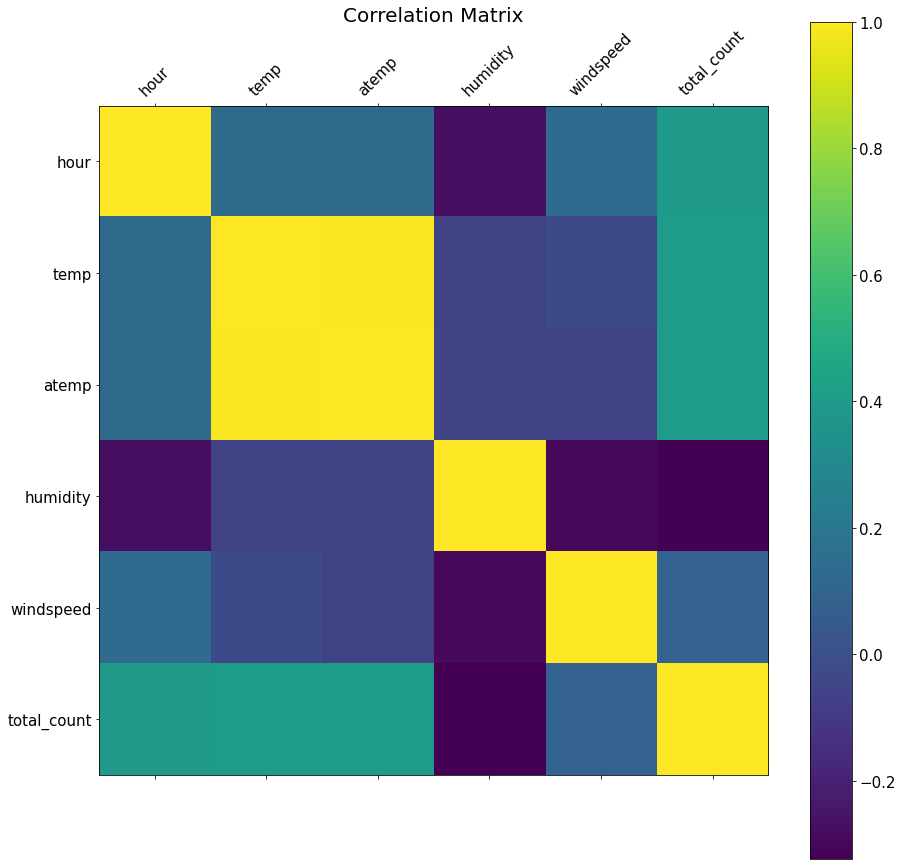

In [8]:
#Correlation Matrix
f = plt.figure(figsize=(15,15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=15, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=15)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
plt.title('Correlation Matrix', fontsize=20)

Different view of the distribution:

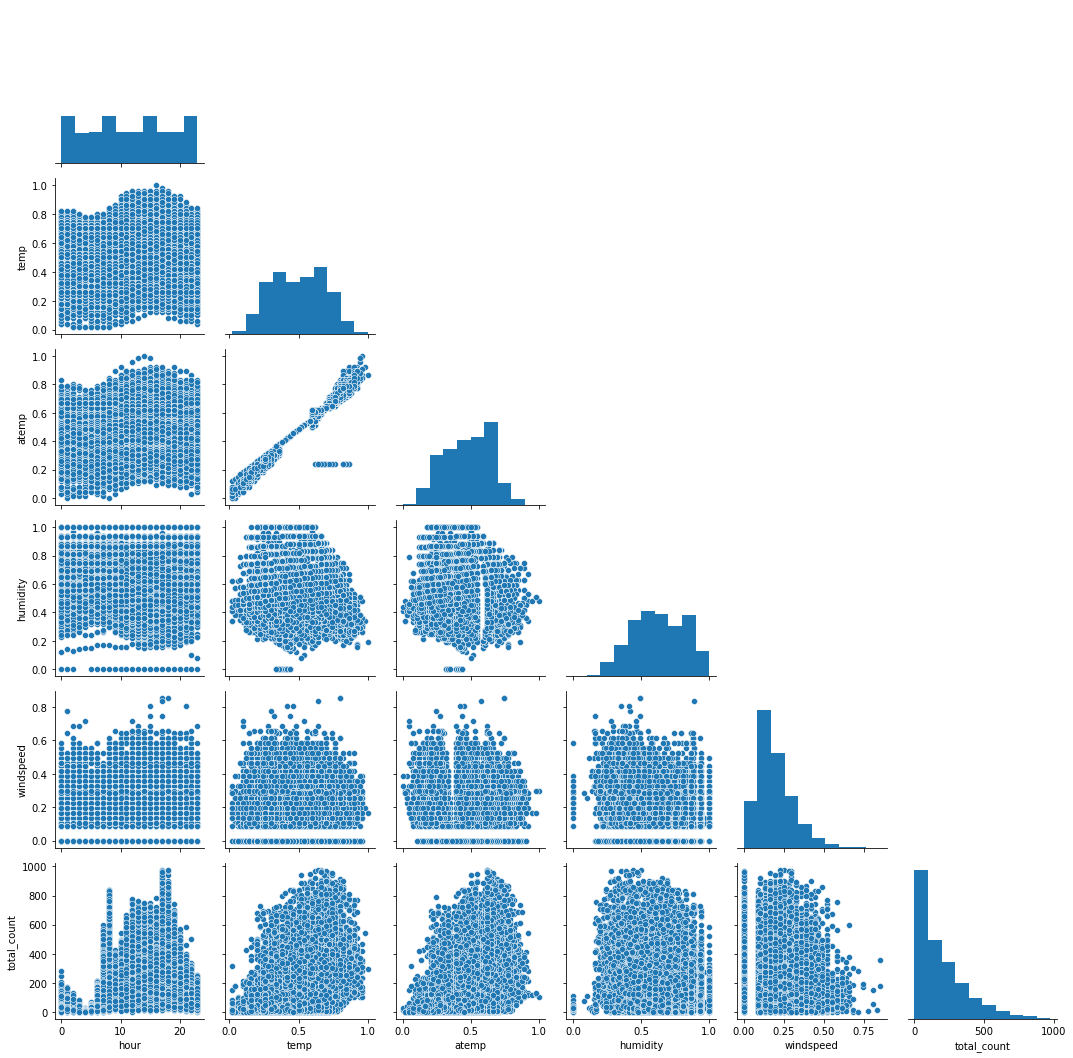

In [9]:
plot = sns.PairGrid(df, corner=True)
plot.map_lower(sns.scatterplot)
plot.map_diag(plt.hist)

### Part 2: Data Engineering
1. Discussion on missing values and outliers
2. Treatment of text and date features
3. Generation of extra features and studying the influence of combinations of features
4. Giving new insights on what seems relevant for prediction and what does not
6. Use of scikit-learn pipelines to perform transformations

Because we are dealing with a time serie (hourly data) we decided to fill the nan using the interpolate method, as we realized that one value missing would be very close to its neighbours. Once this was done, we dummified the feature ['weather_condition'] as it only contained 5 different values

In [10]:
df = df.interpolate()
df = df.interpolate(method='ffill')
df = pd.get_dummies(df, columns=['weather_condition'])

Giving more precise names to all weather condition columns, as the names are too long and they are not easy to comprehend.

In [11]:
df = df.rename(columns = {'weather_condition_Clear, Few clouds, Partly cloudy, Partly cloudy':'Good_weather', 'weather_condition_Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog':'Bad_weather','weather_condition_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds': 'Semi_bad_weather','weather_condition_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist':'Cloudy'})

In [12]:
train = df['2011-01-01':'2012-09-30']
test  = df['2012-10-01':'2012-12-31']

We reset the index because y should not be two dimensional (date as index & actual values for y), thus we reset the index.

In [13]:
train = train.reset_index()
test = test.reset_index()

After interpolating the NaNs, we do not have any NaNs left.

In [14]:
train.isnull().sum()

datetime            0
hour                0
temp                0
atemp               0
humidity            0
windspeed           0
total_count         0
Good_weather        0
Bad_weather         0
Semi_bad_weather    0
Cloudy              0
dtype: int64

Splitting train and test data into explanatory variables and our target (y).

In [15]:
y_train = train["total_count"]
y_test = test["total_count"]

Setting back the index back to datetime as we need it for x (just not for y).

In [16]:
train = train.set_index('datetime')
test = test.set_index('datetime')

In [17]:
x_train = train.copy().drop(["total_count"], axis=1) 
x_test = test.copy().drop(["total_count"], axis=1) 
x_train

,hour,temp,atemp,humidity,windspeed,Good_weather,Bad_weather,Semi_bad_weather,Cloudy
datetime,,,,,,,,,
2011-01-01,0,0.24,0.2879,0.81,0.0000,1,0,0,0
2011-01-01,1,0.22,0.2727,0.80,0.0000,1,0,0,0
2011-01-01,2,0.22,0.2727,0.80,0.0000,1,0,0,0
2011-01-01,3,0.24,0.2879,0.75,0.0000,1,0,0,0
2011-01-01,4,0.24,0.2879,0.75,0.0000,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2012-09-30,19,0.50,0.4848,0.72,0.1343,0,0,1,0
2012-09-30,20,0.50,0.4848,0.72,0.1343,0,0,1,0
2012-09-30,21,0.50,0.4848,0.68,0.0000,1,0,0,0


After running the least amount of transformation necessary for the two models, we ran a Linear Regression and a RandomForest Regressor to set a benchmark and to see our improvement from here.

### Baseline Models (No outliers, no scaling)

In [18]:
#Linear Regression Model 
clf = LinearRegression()
clf.fit(x_train, y_train)
result = clf.predict(x_test)
clf.score(x_test, y_test)

0.1436130869310136

In [19]:
clf_rf = RandomForestRegressor(n_estimators=150, min_samples_split=2)
clf_rf.fit(x_train,y_train)
result_rf = clf_rf.predict(x_test)
clf_rf.score(x_test, y_test)

0.4875462163105392

After obtaining these two relatively low score, we continued to clean our data and checked for improvement regulary in the score.

### Handling Outliers

As a first step in handling outliers, we separated our numerical feature from our categorical features. As our categorical feature are dummified and range from 0-1, there is no need to check for outliers in these columns.

In [20]:
x_train.dtypes

hour                  int64
temp                float64
atemp               float64
humidity            float64
windspeed           float64
Good_weather          uint8
Bad_weather           uint8
Semi_bad_weather      uint8
Cloudy                uint8
dtype: object

In [21]:
for col in x_train.columns:
    if col in x_train.filter(regex='weather|Cloudy').columns:
        x_train[col] = x_train[col].astype('category')

for col in x_test.columns:
    if col in x_test.filter(regex='weather|Cloudy').columns:
        x_test[col] = x_test[col].astype('category')

In [22]:
x_train_cat = list(x_train.select_dtypes(include=["category"]).columns)
x_train_num = list(set(x_train.columns) - set(x_train_cat))

x_test_cat = list(x_test.select_dtypes(include=["category"]).columns)
x_test_num = list(set(x_test.columns) - set(x_test_cat))

For better visualisation, we plotted the boxplots for the numerical features to see in which columns they appeared.

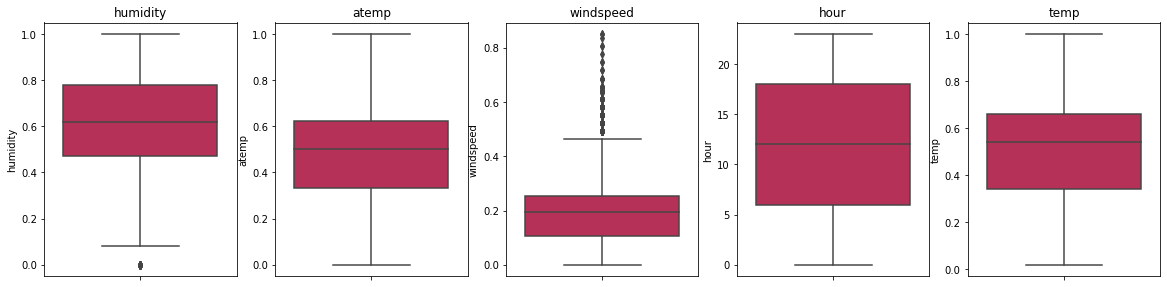

In [23]:
# Box-plot to take a look at outliers

fig, axes = plt.subplots(1, 5, figsize=(20,3))
plt.subplots_adjust(top=1.3)
                    
axes = axes.ravel()

cols = x_train_num #select only the numerical columns that are not binary 

for i, feature in enumerate(cols):
    sns.boxplot(y=x_train[feature], ax=axes[i], palette = 'rocket')
    axes[i].set_title(feature)

As seen on the boxplot above, only two columns (windspeed & humidity) included outliers in their distribution. Let's deal with them.

We defined a function that calculates the theoretical min and the max of each feature using the interquartile range and set the threshold for outliers as 1.5 * the interquartile range, either above Q75 or below Q25. We passed through this function both our x_train and x_test, but outliers on the x_test get replaced with NaNs based on the interquartile range of x_train (if we had used the IQR of the test data we would basically fit our model on the test data).

We replaced the outliers identified as null values to interpolate later. Since we have time series data, interpolation makes sense. We expect the values before and after an NaN to be similar to the NaN.

In [24]:
#replace outliers with nan 
def outliers_to_nan(data1,data2):
    #outliers_to_nan(numerical_data) #function to replace outliers with NaN
    for feature in x_train_num:
        q75,q25 = np.percentile(data1[feature],[75,25])
        intr_qr = q75-q25
        maximum = q75+(1.5*intr_qr)
        minimum = q25-(1.5*intr_qr)
        data1[feature] = np.where((data1[feature] > maximum) | (data1[feature] < minimum),
                                 np.nan,
                                 data1[feature]
                                )
        data2[feature] = np.where((data2[feature] > maximum) | (data2[feature] < minimum),
                                 np.nan,
                                 data2[feature]
                                )
outliers_to_nan(x_train, x_test)

As expected, only two columns which contained outliers now contain missing values. We interpolated these new missing values to keep the data close to the neighbouring values.

In [25]:
x_train.isna().sum()

hour                  0
temp                  0
atemp                 0
humidity             22
windspeed           308
Good_weather          0
Bad_weather           0
Semi_bad_weather      0
Cloudy                0
dtype: int64

In [26]:
x_train = x_train.interpolate(method='ffill')
x_test = x_test.interpolate(method='ffill')

After using forward fill, we do not have NaNs (=outliers) in the dataset anymore (see table + graphs).

In [27]:
x_train.isna().sum()

hour                0
temp                0
atemp               0
humidity            0
windspeed           0
Good_weather        0
Bad_weather         0
Semi_bad_weather    0
Cloudy              0
dtype: int64

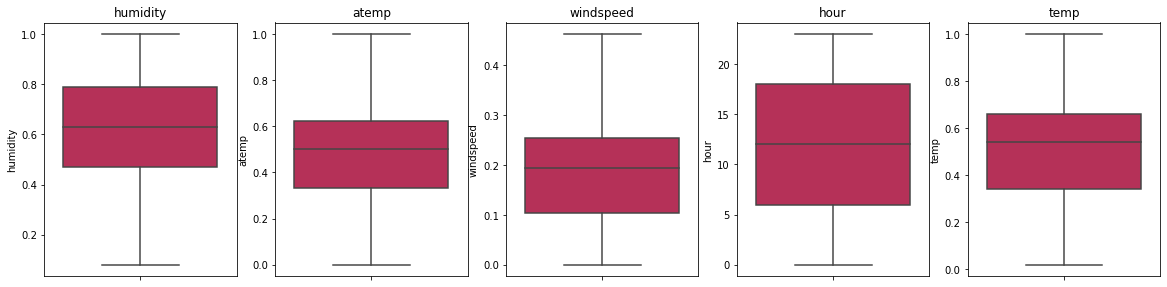

In [28]:
# Box-plot to take a look at outliers

fig, axes = plt.subplots(1, 5, figsize=(20,3))
plt.subplots_adjust(top=1.3)
                    
axes = axes.ravel()

cols = x_train_num #select only the numerical columns that are not binary 

for i, feature in enumerate(cols):
    sns.boxplot(y=x_train[feature], ax=axes[i], palette = 'rocket')
    axes[i].set_title(feature)

We run both models (Linear Regression and Random Forest Regressor) again, our accuracy score has improved slightly.

In [29]:
#Linear Regression Model 
clf = LinearRegression()
clf.fit(x_train, y_train)
result = clf.predict(x_test)
clf.score(x_test, y_test)

0.14481132790712192

In [30]:
clf_rf = RandomForestRegressor(n_estimators=150, min_samples_split=2)
clf_rf.fit(x_train,y_train)
result_rf = clf_rf.predict(x_test)
clf_rf.score(x_test, y_test)

0.48777431457895515

### Feature Engineering

The function below transform the datetime column to split it into multiple different columns to get more information.

The following information are extracted from the datetime column.

- the number of weeks 1- 52
- the year
- the month
- the day in the month
- weekday and weekend are defined accoring to the number in the day column

To simplify the hour column, we used classified the number into 1 = is_daylight or 0 = if it's not as we expect demand to be correlated with the sight (=light).

With the US-holiday library imported before, we created a new column to see if a specific day was marked as a holiday. We expect demand to be higher on holidays.

As we saw in EDA, peak times are when people go to work and go back home. Therefore we created peak_work_hour to take this information into account.
Moreover, we already saw seasonality in the demand plot. This is the reason why we created a seasons feature that we later dummified.

We apply this function both on x_train and x_test to maintain the same level of transformation.

In [31]:
# defining function for feature creation to be able to pass on different datasets
def feature_creation(data):
    
    #reseting index
    data = data.reset_index()
    #renaming dteday
    data = data.rename(columns={'dteday':'datetime'})
    #time-related features
    data["week"] = data["datetime"].dt.week
    data["year"] = data["datetime"].dt.year
    data["month"] = data["datetime"].dt.month
    data["day"] = data["datetime"].dt.day
    #data["hour"] = data["datetime"].dt.hour
    data["weekday"] = data["datetime"].dt.weekday
    data["weekend"] = data["weekday"].map(lambda x: 1*(x>4))
    data['is_daylight'] = np.where(data['hour'].isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), 1, 0)

    holiday_list = []
    for date in holidays.UnitedStates(years=[2011, 2012]).items():
        holiday_list.append(str(date[0]))
    data['holiday'] = np.where(data['datetime'].isin(holiday_list), 1, 0)
    data['peak_work_hour'] = np.where(data['hour'].isin([8, 17, 18])| (data['holiday'].isin([0])), 1, 0)
    #weekdays
    weekday_to_string = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
    data["weekday_string"] = data["weekday"].apply(lambda x: weekday_to_string[x])
    #seasons
    seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall',
        10: 'Fall', 11: 'Fall', 12: 'Winter'}
    data["season"] = data["month"].apply(lambda x: seasons[x])

    data = pd.get_dummies(data, columns=['weekday_string', 'season'])
    
    season_list = ['season_Spring','season_Summer','season_Fall','season_Winter']
    for seas in season_list:
        if seas in data.columns:
            continue
        else:
            data[seas] = 0
        
    data = data.set_index('datetime')
    
    return data

In [32]:
x_train = feature_creation(x_train)
x_test = feature_creation(x_test)

<ipython-input-31-0cfeaa9a1a8e>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data["week"] = data["datetime"].dt.week


To get a better understanding of the newly created variables we plot graphs that could give us more insights.
As we suspected, peak hours are at 8am and 17-18.

In [33]:
#concatenate x & y train to be able to plot demand related graphs
x_train_new = x_train.reset_index()
y_train_new = y_train.reset_index()
full_train = pd.concat([x_train_new, y_train_new], axis=1, join='inner')

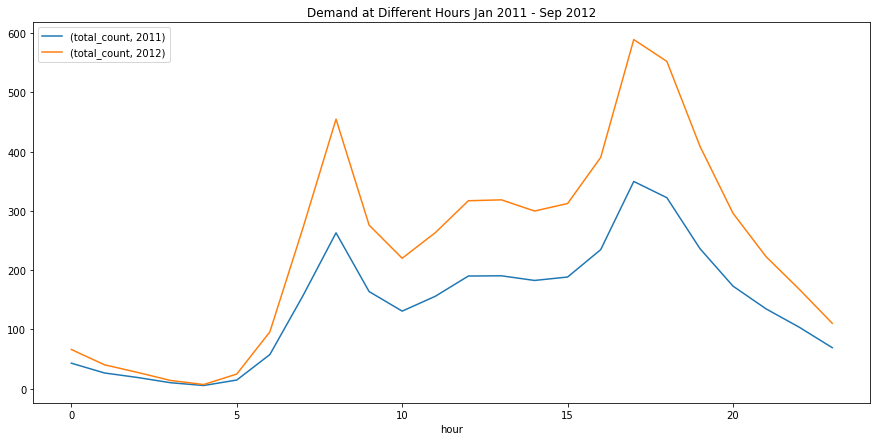

In [34]:
#plot demand at different hours
demand = pd.pivot_table(full_train, index=['hour'],columns=['year'], values=['total_count'])
demand.plot(figsize=(15, 7)).set_title('Demand at Different Hours Jan 2011 - Sep 2012')
plt.legend(loc="upper left")

The weekends show different demand patterns than weekdays. On the weekends (weekday = 5 & 6) we can see clear spikes of demand between 10 - 15:00. These hours have lower demand during workdays (weekday = 0 - 4) because people are at work that time. Weekdays on the other hand have spikes of demand at 8 and at 17:00-18:00 (times where people go to work and get home from work).

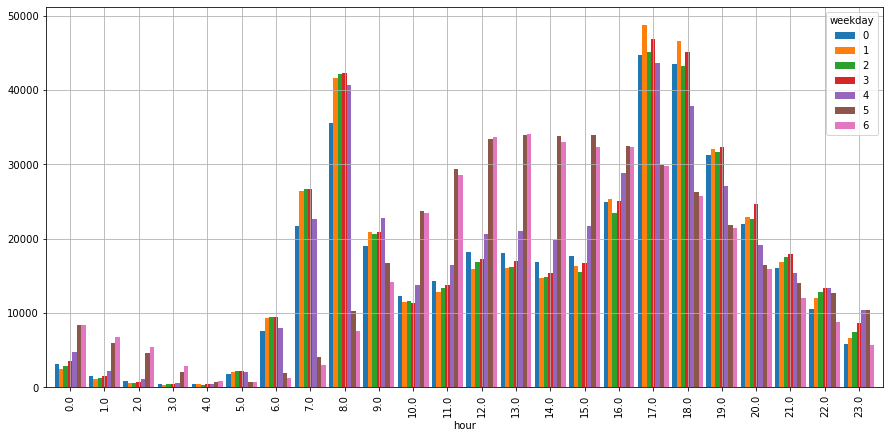

In [35]:
#demand per hour and day of the week (with Monday = 0 and Sunday = 6)
hourly = full_train.copy().groupby(['hour', 'weekday'])['total_count'].agg('sum').unstack()
hourly.plot(kind = 'bar', figsize = (15,7), width = 0.9);
plt.grid(True)

In [36]:
#Linear Regression Model 
clf = LinearRegression()
clf.fit(x_train, y_train)
result1 = clf.predict(x_test)
clf.score(x_test, y_test)
r2_score(y_test, result1)

0.43147565367239105

We scale our data in a pipeline as features are on different scales. The R^2for Linear Regression went up from 14% to 43%. Hurray!!
For Random Forest Regressor we improved from 49% to 86%.

In [37]:
#Linear Regression in a pipeline
pipeLR = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LinearRegression())])
pipeLR.fit(x_train,y_train)
y_test_pred_LR = pipeLR.predict(x_test)
pipeLR.score(x_test,y_test)

0.42911952828691746

In [38]:
clf_rf = RandomForestRegressor(n_estimators=150, min_samples_split=2)
clf_rf.fit(x_train, y_train)
result_rf = clf_rf.predict(x_test)
clf_rf.score(x_test, y_test)

0.8622504111840352

In [39]:
#Random Forest Regressor 
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", RandomForestRegressor(random_state=42))
])
pipe.fit(x_train,y_train)
y_test_pred = pipe.predict(x_test)
pipe.score(x_test,y_test)

0.8627904420819179

### Feature Selection

With the creation of new features, the dimension of our datasets increased a lot. It is most likely that not all the newly-created feature play a same role in predicting our target variable. Possibly some of them are correlated to each other and are therefore filling the model with unecessary noise.

We plot Information Gain of all features. 
The most important features for our model are:
- temp
- is_daylight
- atemp
- year
- holiday
- humidity
- peak_hour

These variables make sense: If temperature is moderate-high, people are more likely to go by bike. Moreover, you want to bike during the day when there is light. Atemp is highly correlated with temp, thus also highly important. We can think about dropping it.
On public holidays people have more time therefore more time to go outside and rent a bike.
During peak hours before and after work demand for bikes is higher, thus it makes sense this feature is important for our model.

In [40]:
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)
importance = pd.DataFrame({"features":x_train.columns, "coefficient":linear_reg.coef_}).sort_values("coefficient")

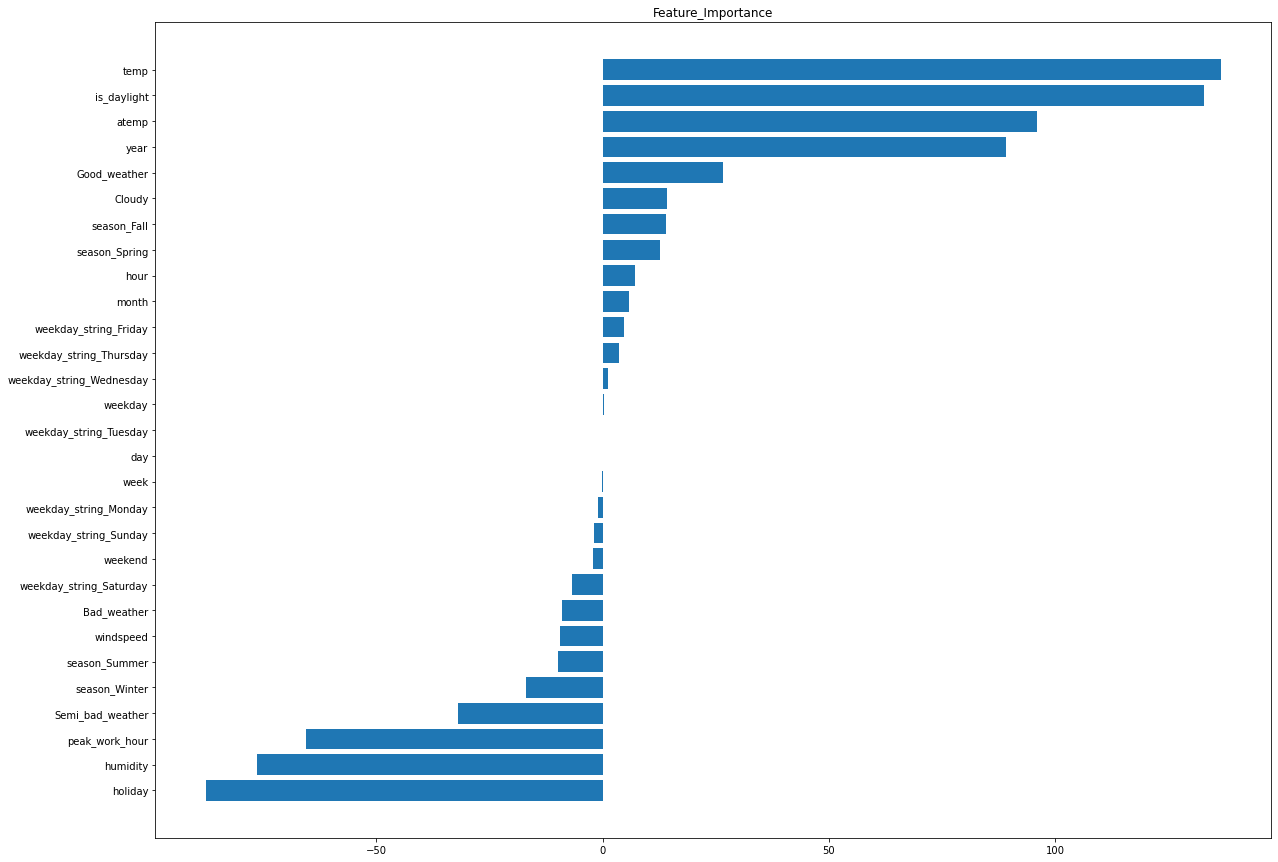

In [41]:
fig, ax = plt.subplots(figsize=(20,15))
plt.barh(importance["features"], importance["coefficient"])
plt.title("Feature_Importance")
plt.show()

In later models we will try dropping different features that had low feature importance and see which one results in the highest accuracy:
- weekday
- all weekday strings
- day
- week

In [42]:
importance.sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

,features,coefficient
1,temp,136.533375
15,is_daylight,132.948905
2,atemp,96.004572
10,year,89.196740
5,Good_weather,26.647672
8,Cloudy,14.300384
25,season_Fall,14.040827
26,season_Spring,12.727469
0,hour,7.027041
11,month,5.702694


We ran a correlation to see which one (if any) were correlated with each other and returned the first 10:
- temp     atemp                      0.987316
- week     month                      0.966075
- holiday  peak_work_hour             0.933087
- weekday  weekend                    0.791419

Based on the score above we decided to remove one of each feature where the correlation was higher that 0.95 to remove noise.

In [43]:
#find features with high correlation
corr_matrix = x_train.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
sol[:10]

<ipython-input-43-66c2fdf584b1>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


temp     atemp                      0.987316
week     month                      0.966075
holiday  peak_work_hour             0.933087
weekday  weekend                    0.791419
temp     season_Summer              0.664061
         season_Winter              0.650603
atemp    season_Winter              0.648147
weekend  weekday_string_Friday      0.645591
         weekday_string_Saturday    0.643875
atemp    season_Summer              0.641855
dtype: float64

We decided to drop features with the lowest absolute feature importance as well as the most correlated variables. This did not improve our score but as it did not add value to our model we still decided to drop them. In addition, for unseen data it might make a difference.

In [44]:
to_drop = ["atemp", "week", "peak_work_hour","day","weekday_string_Tuesday","weekday_string_Wednesday"]

In [45]:
x_train = x_train.drop(to_drop, axis=1)
x_test = x_test.drop(to_drop, axis=1)
pipe.fit(x_train,y_train)
#not increasing accuracy but best practice to drop variables that are highly correlated - removing noise
pipe.score(x_test,y_test)

0.8605741863127689

### Part 3: Machine Learning
- Choosing sensible models (linear and non-linear) (done previously)
- Tuning model parameters with validation
- Obtaining accurate predictions in test
- Plotting predictions vs reality for additional insights

Tuning the parameters, optimizing parameters with GridSearch.

In [46]:
from sklearn.model_selection import GridSearchCV

# reduced grid search just to show some results
param_grid = {
    "model__n_estimators": [30, 50],
    "model__max_features": [0.6, 0.7, 0.5],
    "model__max_samples": [0.7, 0.8, 0.9],
    "model__min_samples_split": [4,5,6],
    "model__min_samples_leaf": [2,3],
    "model__max_depth": [10 ,15, 20]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=1, # if you want to use your computer set this to 1 or 2 or your gridsearch will suck up all your processor power
    verbose=2
)

grid.fit(x_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END model__max_depth=10, model__max_features=0.6, model__max_samples=0.7, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=30; total time=   0.2s
[CV] END model__max_depth=10, model__max_features=0.6, model__max_samples=0.7, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=30; total time=   0.2s
[CV] END model__max_depth=10, model__max_features=0.6, model__max_samples=0.7, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=30; total time=   0.2s
[CV] END model__max_depth=10, model__max_features=0.6, model__max_samples=0.7, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=50; total time=   0.3s
[CV] END model__max_depth=10, model__max_features=0.6, model__max_samples=0.7, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=50; total time=   0.3s
[CV] END model__max_depth=10, model__max_features=0.

KeyboardInterrupt: 

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", 
     RandomForestRegressor(random_state=42,
                           max_depth=20,
                           max_features=0.6,
                           max_samples= 0.8,
                           min_samples_leaf= 2,
                           min_samples_split= 4,
                           n_estimators= 30)
    )
    ])

In [47]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', RandomForestRegressor(random_state=42))])

In [50]:
y_test_predicted = pipe.predict(x_test)

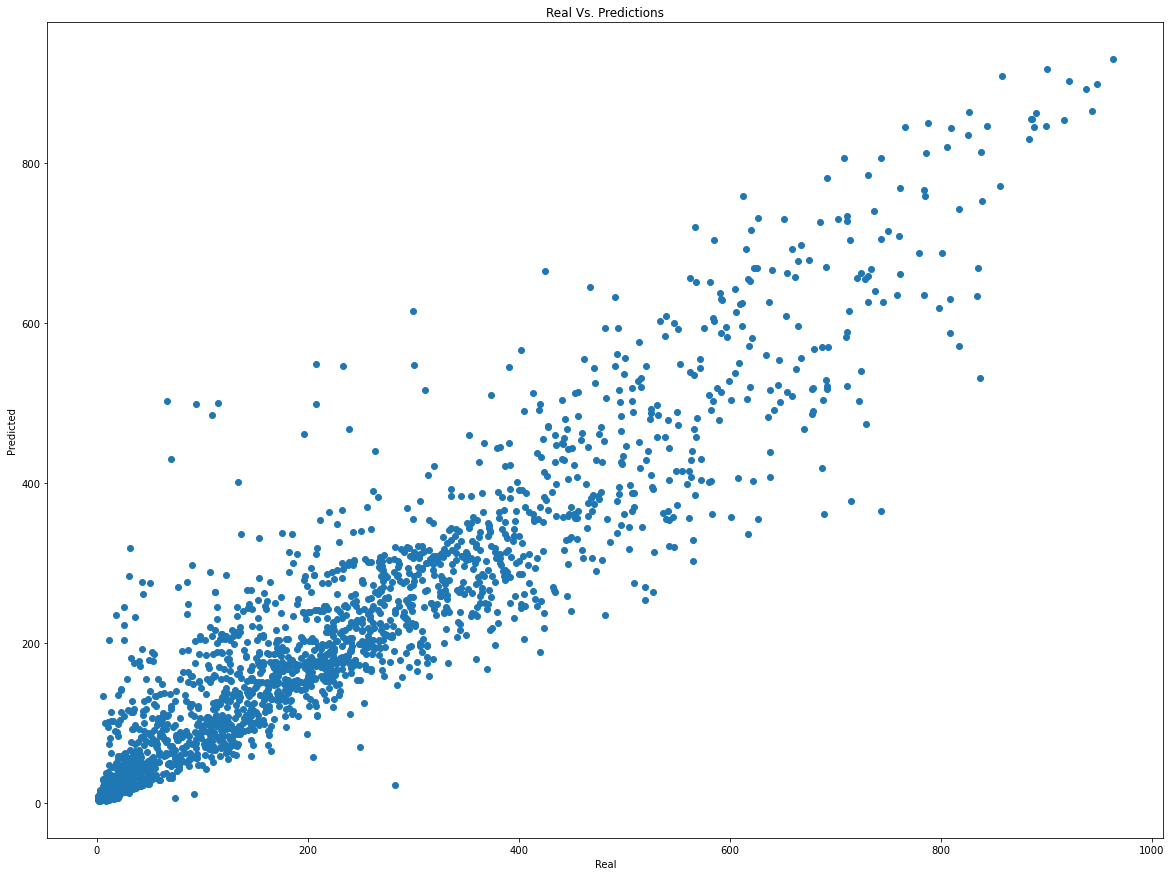

In [51]:
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test,y_test_predicted)
plt.title("Real Vs. Predictions")
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.show()

In [55]:
final_df = pd.DataFrame(test['total_count'])

In [56]:
final_df['hour'] = test['hour']

In [58]:
final_df['prediction'] = y_test_predicted

In [59]:
final_df

,total_count,hour,prediction
datetime,,,
2012-10-01,45,0,72.06
2012-10-01,18,1,17.41
2012-10-01,12,2,10.69
2012-10-01,7,3,7.26
2012-10-01,10,4,6.31
...,...,...,...
2012-12-31,119,19,211.05
2012-12-31,89,20,158.61
2012-12-31,90,21,123.91


Plotting real values vs predictions. Our predictions are really close to the true values. Our model predicts well.

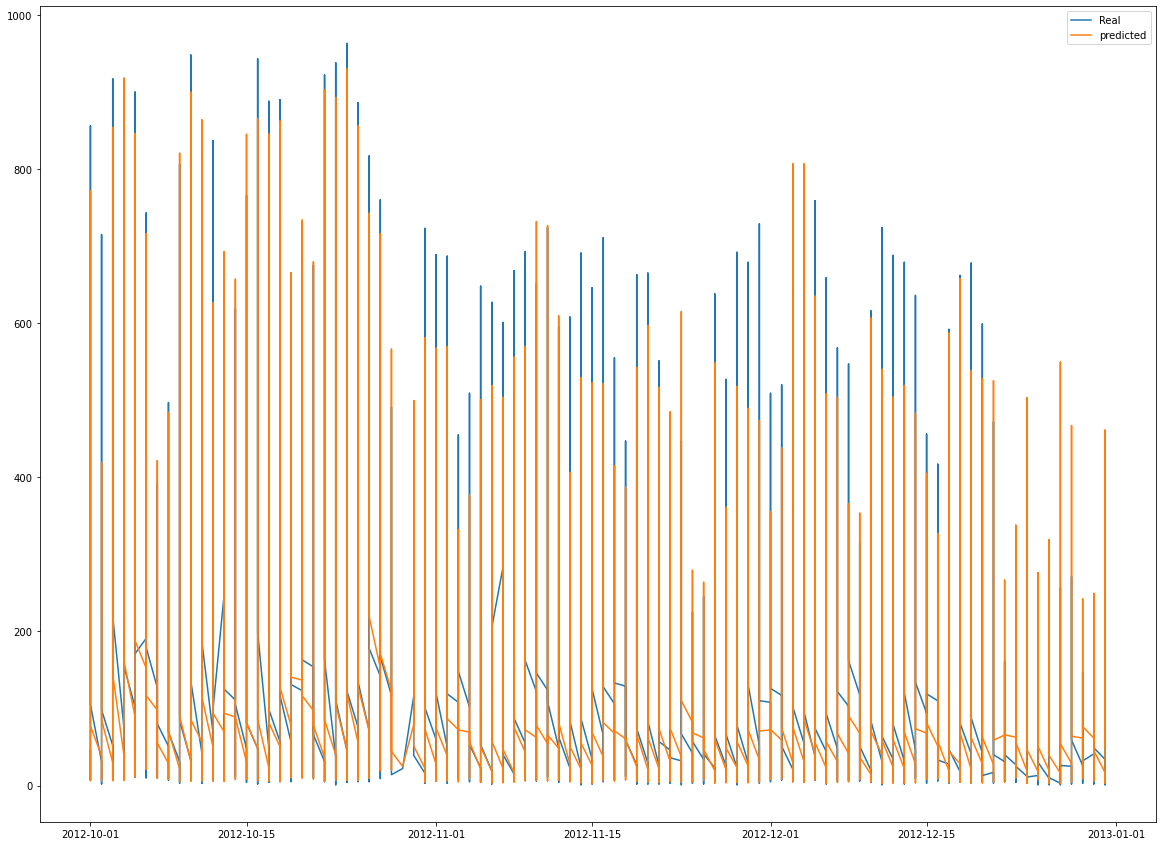

In [60]:
fig, ax = plt.subplots(figsize=(20,15))
plt.plot(final_df['total_count'],label='Real')
plt.plot(final_df['prediction'],label="predicted")
plt.legend()
plt.show()